# Geospatial Analysis of Los Angeles 

### In this notebook, we leverage Foursquare location data to aid us in better understanding the cities in Los Angeles

#### Introduction
We try to aid people who are thinking of migrating to Los Angeles to better understand the cities, to decide which area may be best suited for them to move into. We assume that an important feature that people consider when making a decision is the type of venues available within the city.

#### Data
The data that we'll be using will mainly come from exploring Foursquare's data of Los Angeles, and along the way we might include other data sources (e.g., SimpleMaps for Los Angeles City Data) into this workbook. For Foursquare's data, we will look into the restaurants/landmarks within each city, to find distinct characteristics within the city that we may be able to cluster together.

In [1]:
import pandas as pd # pandas, numpy and requests
import numpy as np
import requests

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# !conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


In [2]:
# data obtained from simplemaps.com
us_data = pd.read_csv('data/uszips.csv') # read the data

la_df = us_data[us_data.county_name == 'Los Angeles'] # filter data to solely on los angeles

la_df = la_df.drop_duplicates(subset=['city'], keep='first') # remove duplicate city == Los Angeles, but keep the first of each duplicate

la_df.head(5)

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,all_county_weights,imprecise,military,timezone
128,90822,33.7784,-118.1186,Long Beach,CA,California,True,NaN,117,278.0,6037,Los Angeles,{'06037':100},False,False,America/Los_Angeles
135,90073,34.0546,-118.4570,Los Angeles,CA,California,True,NaN,539,613.7,6037,Los Angeles,{'06037':100},False,False,America/Los_Angeles
1117,90069,34.0938,-118.3817,West Hollywood,CA,California,True,NaN,20483,3741.0,6037,Los Angeles,{'06037':100},False,False,America/Los_Angeles
1364,91210,34.1445,-118.2565,Glendale,CA,California,True,NaN,328,2877.0,6037,Los Angeles,{'06037':100},False,False,America/Los_Angeles
1492,91384,34.5307,-118.6864,Castaic,CA,California,True,NaN,29855,106.2,6037,Los Angeles,{'06037':100},False,False,America/Los_Angeles


In [3]:
la_df = la_df.reset_index(drop=True).drop(['zip', 
                                          'state_id', 
                                          'state_name', 
                                          'zcta', 
                                          'parent_zcta', 
                                          'population', 
                                          'density', 
                                          'county_fips', 
                                          'all_county_weights', 
                                          'imprecise', 
                                          'military', 
                                          'timezone'], axis=1)

la_df.head(5)

,lat,lng,city,county_name
0,33.7784,-118.1186,Long Beach,Los Angeles
1,34.0546,-118.4570,Los Angeles,Los Angeles
2,34.0938,-118.3817,West Hollywood,Los Angeles
3,34.1445,-118.2565,Glendale,Los Angeles
4,34.5307,-118.6864,Castaic,Los Angeles


In [4]:
# la_df.loc[la_df['city'] == 'Glendale'] # check if exist

In [5]:
address = 'Los Angeles'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536834, -118.2427669.


In [6]:
# create map of Los Angeles using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, city in zip(la_df['lat'], la_df['lng'], la_df['city']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

#### Next, we explore with Foursquare and see what's around the center of Los Angeles.

In [7]:
CLIENT_ID = 'SEYTRO4BOD23NFTGK3G5BAWV0U2ZFVUU0RG4PUYP5SUTQNYV' # your Foursquare ID
CLIENT_SECRET = 'BJQIOU5QUQ3VJBY0T22V4PRHYORTWOFEHW1LN5RRVIDZ5ITI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SEYTRO4BOD23NFTGK3G5BAWV0U2ZFVUU0RG4PUYP5SUTQNYV
CLIENT_SECRET:BJQIOU5QUQ3VJBY0T22V4PRHYORTWOFEHW1LN5RRVIDZ5ITI


In [8]:
# type your answer here
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=SEYTRO4BOD23NFTGK3G5BAWV0U2ZFVUU0RG4PUYP5SUTQNYV&client_secret=BJQIOU5QUQ3VJBY0T22V4PRHYORTWOFEHW1LN5RRVIDZ5ITI&v=20180605&ll=34.0536834,-118.2427669&radius=500&limit=100'

In [9]:
results = requests.get(url).json()
# results

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Grand Park,Park,34.055034,-118.245179
1,Renegade Craft Fair,Arts & Crafts Store,34.054445,-118.244471
2,Badmaash,Indian Restaurant,34.051342,-118.244571
3,Redbird,American Restaurant,34.050666,-118.244068
4,Kinokuniya Bookstore,Bookstore,34.050145,-118.242246


In [12]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

37 venues were returned by Foursquare.


### We then proceed to explore Neighbourhoods in Los Angeles

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
la_venues = getNearbyVenues(names=la_df['city'],
                                  latitudes=la_df['lat'],
                                  longitudes=la_df['lng']
                           )

Long Beach
Los Angeles
West Hollywood
Glendale
Castaic
Valyermo
Llano
Lancaster
Acton
North Hollywood
Santa Clarita
Venice
Lawndale
Santa Monica
Northridge
Winnetka
Baldwin Park
Palmdale
Canoga Park
Van Nuys
Hermosa Beach
Whittier
Glendora
San Pedro
Bell Gardens
El Monte
San Marino
Newhall
Redondo Beach
Inglewood
San Fernando
Maywood
Pasadena
Pacoima
Sunland
Mission Hills
Canyon Country
Torrance
Playa Del Rey
South El Monte
Lake Hughes
Hacienda Heights
Granada Hills
Wilmington
Valencia
Paramount
Alhambra
Gardena
Norwalk
Rowland Heights
Marina Del Rey
Malibu
Pomona
Altadena
Chatsworth
Lakewood
La Puente
El Segundo
Huntington Park
West Covina
Hawthorne
Covina
Monrovia
La Verne
Sierra Madre
Artesia
Compton
South Gate
Rosemead
La Canada Flintridge
North Hills
Woodland Hills
Sylmar
Signal Hill
Walnut
Monterey Park
Reseda
Downey
Panorama City
La Mirada
Pico Rivera
South Pasadena
Carson
Manhattan Beach
Sherman Oaks
Azusa
Porter Ranch
Lynwood
Montebello
Burbank
Valley Village
Palos Verdes Peni

In [15]:
la_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Long Beach,33.7784,-118.1186,Afters Ice Cream,33.774749,-118.120477,Ice Cream Shop
1,Long Beach,33.7784,-118.1186,Yogurtland,33.774748,-118.120406,Frozen Yogurt Shop
2,Long Beach,33.7784,-118.1186,Cha For Tea,33.774738,-118.120050,Bubble Tea Shop
3,Long Beach,33.7784,-118.1186,Yogurtland,33.775343,-118.116888,Frozen Yogurt Shop
4,Long Beach,33.7784,-118.1186,L & L Hawaiian Barbecue,33.774725,-118.120188,Hawaiian Restaurant


In [16]:
la_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agoura Hills,6,6,6,6,6,6
Alhambra,20,20,20,20,20,20
Altadena,3,3,3,3,3,3
Arcadia,12,12,12,12,12,12
Artesia,29,29,29,29,29,29
Baldwin Park,5,5,5,5,5,5
Bell Gardens,9,9,9,9,9,9
Bellflower,19,19,19,19,19,19
Beverly Hills,1,1,1,1,1,1


In [17]:
print('There are {} uniques categories.'.format(len(la_venues['Venue Category'].unique())))

There are 272 uniques categories.


In [18]:
import matplotlib.pyplot as plt

la_venues_grouped = la_venues.groupby('Neighborhood').count()


In [19]:
la_venues_grouped = la_venues_grouped.reset_index()


In [20]:
la_venues_grouped['Venue'].astype(float)
la_venues_grouped

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agoura Hills,6,6,6,6,6,6
1,Alhambra,20,20,20,20,20,20
2,Altadena,3,3,3,3,3,3
3,Arcadia,12,12,12,12,12,12
4,Artesia,29,29,29,29,29,29
5,Baldwin Park,5,5,5,5,5,5
6,Bell Gardens,9,9,9,9,9,9
7,Bellflower,19,19,19,19,19,19
8,Beverly Hills,1,1,1,1,1,1
9,Burbank,33,33,33,33,33,33


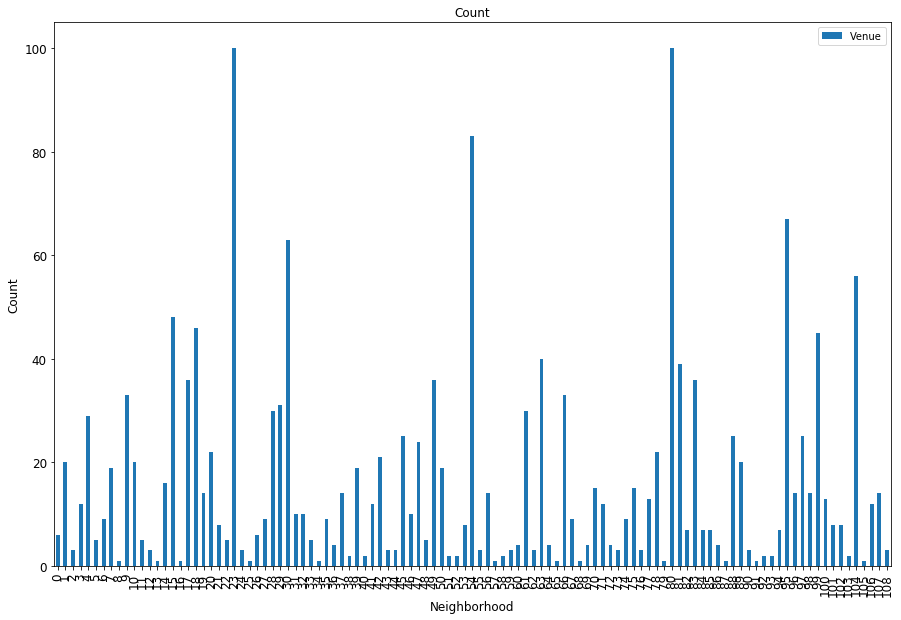

In [21]:
ax = la_venues_grouped[['Neighborhood','Venue']].plot(kind='bar', title ="Count", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Neighborhood", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()


### We next proceed to analyse each category.

In [22]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhood'] = la_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

la_onehot.head()

,Yoga Studio,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
la_onehot.shape

(1726, 272)

In [24]:
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,...,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agoura Hills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alhambra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Altadena,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arcadia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Artesia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.068966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
la_grouped.shape

(109, 272)

In [26]:
num_top_venues = 3

for hood in la_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = la_grouped[la_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agoura Hills----
                        venue  freq
0                       Trail  0.33
1              Scenic Lookout  0.17
2  Construction & Landscaping  0.17


----Alhambra----
                       venue  freq
0  Cajun / Creole Restaurant  0.05
1                Pizza Place  0.05
2          Convenience Store  0.05


----Altadena----
              venue  freq
0  Sushi Restaurant  0.33
1            Garden  0.33
2       Film Studio  0.33


----Arcadia----
                 venue  freq
0  Japanese Restaurant  0.08
1     Asian Restaurant  0.08
2          Golf Course  0.08


----Artesia----
                   venue  freq
0      Indian Restaurant  0.17
1     Chinese Restaurant  0.17
2  Vietnamese Restaurant  0.07


----Baldwin Park----
                        venue  freq
0            Business Service   0.4
1                 Supermarket   0.2
2  Construction & Landscaping   0.2


----Bell Gardens----
                venue  freq
0            Pharmacy  0.11
1       Grocery Store  0.11
2  

            venue  freq
0      Donut Shop  0.07
1  Sandwich Place  0.07
2             Spa  0.07


----Reseda----
                   venue  freq
0  Vietnamese Restaurant  0.33
1            Supermarket  0.08
2        Thai Restaurant  0.08


----Rosemead----
          venue  freq
0   Gas Station  0.25
1  Burger Joint  0.25
2   Pizza Place  0.25


----Rowland Heights----
                venue  freq
0         Tailor Shop  0.33
1          Food Truck  0.33
2  Mexican Restaurant  0.33


----San Dimas----
             venue  freq
0            Diner  0.11
1              Spa  0.11
2  Thai Restaurant  0.11


----San Fernando----
                venue  freq
0  Mexican Restaurant  0.27
1             Brewery  0.07
2      Ice Cream Shop  0.07


----San Gabriel----
           venue  freq
0  Moving Target  0.33
1  Jewelry Store  0.33
2           Food  0.33


----San Marino----
              venue  freq
0            Garden  0.54
1  Sushi Restaurant  0.08
2          Tea Room  0.08


----San Pedro----
    

### Putting these breakdowns into a DataFrame

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = la_grouped['Neighborhood']

for ind in np.arange(la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agoura Hills,Trail,Construction & Landscaping,Video Store,Home Service,Scenic Lookout,Football Stadium,Food Truck,Food Stand,Food Service,Fountain
1,Alhambra,Mexican Restaurant,Train Station,Donburi Restaurant,Convenience Store,Flower Shop,Check Cashing Service,Cajun / Creole Restaurant,Smoke Shop,Burger Joint,Gift Shop
2,Altadena,Garden,Sushi Restaurant,Film Studio,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Women's Store
3,Arcadia,Bank,Golf Course,Coffee Shop,BBQ Joint,Convenience Store,Asian Restaurant,Vegetarian / Vegan Restaurant,Bookstore,Korean Restaurant,Steakhouse
4,Artesia,Indian Restaurant,Chinese Restaurant,Bubble Tea Shop,Vietnamese Restaurant,Fast Food Restaurant,Asian Restaurant,Salon / Barbershop,Tea Room,Taiwanese Restaurant,Thai Restaurant


### We proceed to run k-means cluster to cluster these areas

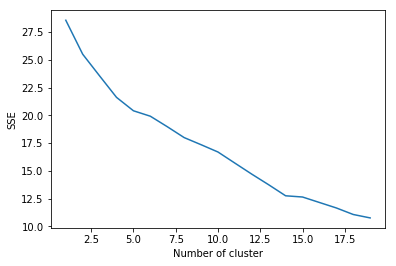

In [29]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

sse = {}

la_grouped_clustering = la_grouped.drop('Neighborhood', 1)

for k in range(1,20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(la_grouped_clustering)
    la_grouped_clustering["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

This clearly seems like a problem as it seems like there is no elbow point from 1 to 20 of the kmeans clustering.

In [30]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

la_grouped_clustering = la_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1], dtype=int32)

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

la_merged = la_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='city')

la_merged.head() # check the last columns!

,lat,lng,city,county_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,33.7784,-118.1186,Long Beach,Los Angeles,1.0,Coffee Shop,Frozen Yogurt Shop,Sushi Restaurant,Fast Food Restaurant,Pharmacy,Bubble Tea Shop,General College & University,Food Court,Big Box Store,Chinese Restaurant
1,34.0546,-118.4570,Los Angeles,Los Angeles,1.0,Intersection,Italian Restaurant,Bank,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Flea Market
2,34.0938,-118.3817,West Hollywood,Los Angeles,1.0,Italian Restaurant,Burger Joint,Shipping Store,Pizza Place,Spa,Clothing Store,New American Restaurant,French Restaurant,Sushi Restaurant,American Restaurant
3,34.1445,-118.2565,Glendale,Los Angeles,1.0,Clothing Store,Japanese Restaurant,Coffee Shop,Electronics Store,Cosmetics Shop,Toy / Game Store,Sushi Restaurant,Gym / Fitness Center,Department Store,Burger Joint
4,34.5307,-118.6864,Castaic,Los Angeles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# drop NA rows due to no results being returned by Foursquare
la_merged.dropna(axis=0, inplace=True)

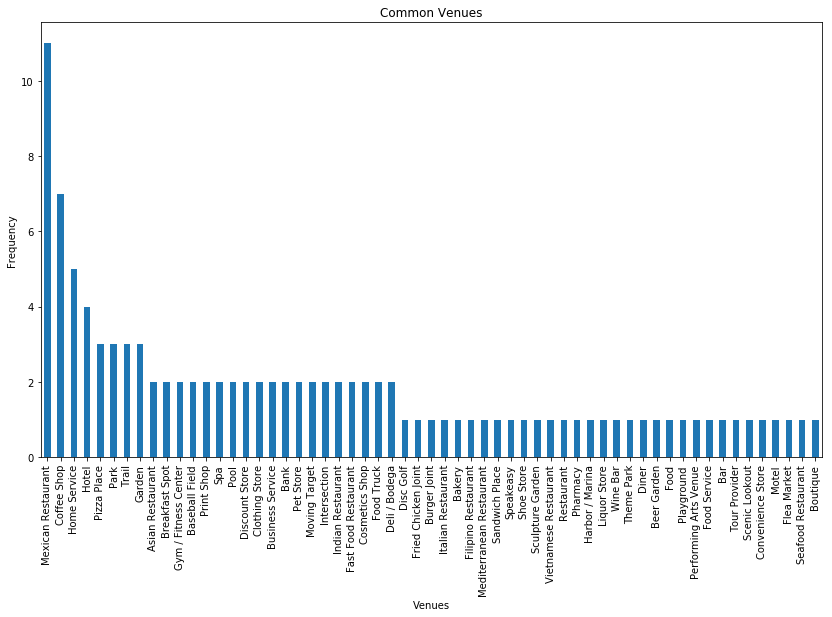

In [42]:
ax = neighborhoods_venues_sorted['1st Most Common Venue'].value_counts().plot(kind='bar',
                                                                                figsize=(14,8),
                                                                                title="Common Venues")
ax.set_xlabel("Venues")
ax.set_ylabel("Frequency")
plt.show()

In [44]:
la_merged.head()

,lat,lng,city,county_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,33.7784,-118.1186,Long Beach,Los Angeles,1.0,Coffee Shop,Frozen Yogurt Shop,Sushi Restaurant,Fast Food Restaurant,Pharmacy,Bubble Tea Shop,General College & University,Food Court,Big Box Store,Chinese Restaurant
1,34.0546,-118.4570,Los Angeles,Los Angeles,1.0,Intersection,Italian Restaurant,Bank,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Flea Market
2,34.0938,-118.3817,West Hollywood,Los Angeles,1.0,Italian Restaurant,Burger Joint,Shipping Store,Pizza Place,Spa,Clothing Store,New American Restaurant,French Restaurant,Sushi Restaurant,American Restaurant
3,34.1445,-118.2565,Glendale,Los Angeles,1.0,Clothing Store,Japanese Restaurant,Coffee Shop,Electronics Store,Cosmetics Shop,Toy / Game Store,Sushi Restaurant,Gym / Fitness Center,Department Store,Burger Joint
7,34.7471,-118.3687,Lancaster,Los Angeles,1.0,Print Shop,Motorcycle Shop,Women's Store,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Football Stadium


In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['lat'], la_merged['lng'], la_merged['city'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
# Taking a look at features of Cluster 0
la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,lng,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,-118.4372,Pool,Women's Store,Food Truck,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Football Stadium


In [47]:
# Taking a look at features of Cluster 1
la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,lng,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,-118.1186,Coffee Shop,Frozen Yogurt Shop,Sushi Restaurant,Fast Food Restaurant,Pharmacy,Bubble Tea Shop,General College & University,Food Court,Big Box Store,Chinese Restaurant
1,-118.4570,Intersection,Italian Restaurant,Bank,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Flea Market
2,-118.3817,Italian Restaurant,Burger Joint,Shipping Store,Pizza Place,Spa,Clothing Store,New American Restaurant,French Restaurant,Sushi Restaurant,American Restaurant
3,-118.2565,Clothing Store,Japanese Restaurant,Coffee Shop,Electronics Store,Cosmetics Shop,Toy / Game Store,Sushi Restaurant,Gym / Fitness Center,Department Store,Burger Joint
7,-118.3687,Print Shop,Motorcycle Shop,Women's Store,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Football Stadium
9,-118.3725,Coffee Shop,Theater,Fast Food Restaurant,Mexican Restaurant,Gym,Dance Studio,Pizza Place,Convenience Store,Italian Restaurant,Bar
11,-118.4634,Boutique,Clothing Store,Pizza Place,Pet Store,Cosmetics Shop,Café,Gym,Yoga Studio,Chocolate Shop,Sushi Restaurant
12,-118.3512,Indian Restaurant,Peruvian Restaurant,Noodle House,Intersection,Cosmetics Shop,Fast Food Restaurant,Thai Restaurant,Grocery Store,Pharmacy,Rental Car Location
13,-118.4925,Clothing Store,American Restaurant,Yoga Studio,Italian Restaurant,Coffee Shop,Sporting Goods Shop,Café,Boutique,Cocktail Bar,Board Shop
15,-118.5754,Convenience Store,Home Service,Bar,Food,Filipino Restaurant,Mexican Restaurant,Taco Place,Latin American Restaurant,Fried Chicken Joint,Donut Shop


In [48]:
# Taking a look at features of Cluster 2
la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,lng,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,-118.3851,Park,Women's Store,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Insurance Office
115,-118.4148,Park,Women's Store,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Insurance Office


In [49]:
# Taking a look at features of Cluster 3
la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,lng,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,-118.5176,Sculpture Garden,Home Service,Construction & Landscaping,Film Studio,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service
33,-118.4208,Home Service,Women's Store,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fish & Chips Shop
42,-118.5075,Home Service,Women's Store,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fish & Chips Shop
69,-118.2052,Home Service,Liquor Store,Trail,Photography Studio,Film Studio,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop
75,-118.1150,Pool,Home Service,Women's Store,Food Service,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand
97,-118.6131,Home Service,Women's Store,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fish & Chips Shop
117,-118.0555,Moving Target,Home Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Women's Store


In [50]:
# Taking a look at features of Cluster 4
la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,lng,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,-118.5576,Hotel,Food Truck,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Women's Store,Fish & Chips Shop
105,-117.8145,Hotel,Food Truck,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Women's Store,Fish & Chips Shop


The End.